# Theory for Energy-Based Models (EBM)

The density given by an EBM is:
\begin{eqnarray*}
p_{\theta}(x) = \frac{\exp(-E_\theta(x))}{Z_\theta},
\end{eqnarray*}
where $E_\theta:\mathbb{R}^d \to \mathbb{R}$ and $Z_\theta=\int \exp(-E_\theta(x)) dx$.

Given samples $x_1,\dots, x_N$ in $\mathbb{R}^d$, we want to find the parameter $\theta$ maximizing the log-likelihood $\max_\theta \sum_{i=1}^N \log p_{\theta}(x_i)$. Since $Z_\theta$ is a function of $\theta$, evaluation and differentiation of $\log p_{\theta}(x)$ w.r.t. $\theta$ involves a typically intractable integral.

## Maximum Likelihood Training with MCMC

We can estimate the gradient of the log-likelihood with MCMC approaches:
\begin{eqnarray*}
\nabla_\theta \log p_\theta(x) = -\nabla_\theta E_\theta(x)-\nabla_\theta 
\log Z_\theta.
\end{eqnarray*}
The first term is simple to compute (with automatic differentiation).

### Question 1 (Maths)
Show that for the second term, we have:
\begin{eqnarray*}
\nabla_\theta \log Z_\theta = \mathbb{E}_{p_{\theta}(x)}\left[-\nabla_\theta E_\theta(x)\right] \left(= \int p_{\theta}(x) \left[-\nabla_\theta E_\theta(x)\right] dx \right).
\end{eqnarray*}

### Solution

\begin{eqnarray*}
\nabla_\theta \log Z_\theta &=& \frac{\nabla_\theta Z_\theta}{Z_\theta}\\
&=& \frac{1}{Z_\theta} \int \nabla_\theta \exp (-E_\theta(x))dx\\
&=& \frac{-1}{Z_\theta} \int \nabla_\theta E_\theta(x) \exp (-E_\theta(x))dx\\
&=& \mathbb{E}_{p_{\theta}(x)}\left[-\nabla_\theta E_\theta(x)\right]
\end{eqnarray*}

Thus, we can obtain an unbiased one-sample Monte Carlo estimate of the log-likelihood gradient by
\begin{eqnarray*}
\nabla_\theta \log Z_\theta \approx -\nabla_\theta E_\theta(\tilde{x}),
\end{eqnarray*}
with $\tilde{x}\sim p_\theta(x)$, i.e. a random sample from the distribution given by the EBM. Therefore, we need to draw random samples from the model. As explained during the course, this can be done using Langevin MCMC. First note that the gradient of the log-probability w.r.t. $x$ (which is the score) is easy to calculate:
\begin{eqnarray*}
\nabla_x \log p_\theta(x) = -\nabla_x E_\theta(x) \text{ since }  \nabla_x \log Z_\theta = 0.
\end{eqnarray*}
Hence, in this case, Langevin MCMC is given by:
\begin{eqnarray*}
x_t = x_{t-1} - \epsilon \nabla_x E_\theta(x_{t-1}) +\sqrt{2\epsilon}z_t, 
\end{eqnarray*}
where $z_t\sim \mathcal{N}(0,I)$. When $\epsilon\to 0$ and $t\to \infty$, $x_t$ will be distributed as $p_\theta(x)$ (under some regularity conditions).

In this homework, we will consider an alternative learning procedure.

## Score Matching

The score (which was used in Langevin MCMC above) is defined as $$ s_\theta(x) = \nabla_x\log p_\theta(x) = -\nabla_x E_\theta(x) = -\left( \frac{\partial E_\theta(x)}{\partial x_1},\dots, \frac{\partial E_\theta(x)}{\partial x_d}\right).$$

If $p(x)$ denote the (unknown) data distribution, the basic score matching objective minimizes:
$$
\mathbb{E}_{p(x)} \|\nabla_x \log p(x) - s_\theta(x)\|^2.
$$

### Question 2 (Maths)

The problem with this objective is that we cannot compute $\nabla_x \log p(x)$ as $p(x)$ is unknown. We can only compute (approximate) averages with respect to $p(x)$ with empirical averages.
Show that we can solve this issue as we have:
$$
\mathbb{E}_{p(x)} \|\nabla_x \log p(x) - s_\theta(x)\|^2 = c + \mathbb{E}_{p(x)}\left[ \sum_{i=1}^d\left ( \frac{\partial E_\theta(x)}{\partial x_i}\right)^2+2\frac{\partial^2 E_\theta(x)}{\partial x^2_i}\right],
$$
where $c$ is a constant (not depending on $\theta$).

### Solution

\begin{eqnarray*}
\mathbb{E}_{p(x)} \|\nabla_x \log p(x) - s_\theta(x)\|^2 &=&\mathbb{E}_{p(x)} \|\nabla_x \log p(x) \|^2 +\mathbb{E}_{p(x)} \| s_\theta(x)\|^2 - 2 \mathbb{E}_{p(x)} \langle \nabla_x \log p(x) , s_\theta(x)\rangle\\
&=& c + \mathbb{E}_{p(x)}\left[ \sum_{i=1}^d\left ( \frac{\partial E_\theta(x)}{\partial x_i}\right)^2\right] - 2 \int p(x)  \langle \frac{\nabla_x p(x)}{p(x)} , s_\theta(x)\rangle dx\\
&=& c + \mathbb{E}_{p(x)}\left[ \sum_{i=1}^d\left ( \frac{\partial E_\theta(x)}{\partial x_i}\right)^2\right] + 2\int p(x) \nabla_x \cdot s_\theta(x) dx,
\end{eqnarray*}
by integration by parts where for a vector valued function $v(x_1,x_2,x_3)$ $\nabla_x \cdot v = \frac{\partial v_1}{\partial x_1} + \frac{\partial v_2}{\partial x_2}+ \frac{\partial v_3}{\partial x_3}$. The statement follows.

## Denoising Score Matching

There are several drawbacks about the score matching approach: computing the trace of the Hessian is expensive and scores will not be accurately estimated in low-density regions, see [Generative Modeling by Estimating Gradients of the Data Distribution](https://yang-song.net/blog/2021/score/#naive-score-based-generative-modeling-and-its-pitfalls)

Denoising score matching is an elegant and scalable solution. Consider the random variable $Y = X+\sigma Z$, where $X\sim p(x)$ and $Z\sim\mathcal{N}(0,I)$. We denote by $p^\sigma(y)$ the distribution of $Y$.


### Question 3 (Maths)
Shows that
$$
\nabla_y\log p^\sigma(y) = -\frac{1}{\sigma}\mathbb{E}\left[ Z |Y=y\right] = -\frac{1}{\sigma}\mathbb{E}\left[ Z |X+\sigma Z=y\right].
$$

### Solution

\begin{eqnarray*}
\nabla_y\log p^\sigma(y) = \frac{\nabla_y p^\sigma(y)}{p^\sigma(y)}
\end{eqnarray*}
We denote by $\varphi$ the density of $\mathcal{N}(0,\sigma^2 I)$. We have $p^\sigma(y) = \int p(x) \varphi(y-x) dx$ so that using the fact that $\nabla_z \varphi(z) = -\frac{z}{\sigma^2} \varphi(z)$, we get
\begin{eqnarray*}
\nabla_y p^\sigma(y) &=& \int p(x) \nabla_y \varphi(y-x) dx\\
&=& \int p(x) \frac{-(y-x)}{\sigma^2} \varphi(y-x) dx \\
&=& -\frac{1}{\sigma}\mathbb{E}\left[ \frac{Y-X}{\sigma} |Y=y\right]\\
&=& -\frac{1}{\sigma}\mathbb{E}\left[ Z |Y=y\right]
\end{eqnarray*}

The denoising score matching objective is now
$$
\mathbb{E}_{p^\sigma(y)}\|\nabla_y \log p^\sigma(y) - s_\theta(y)\|^2,
$$
that we will minimize thanks to a gradient descent in the parameter $\theta$.

### Question 4 (Maths)

Show that
$$
\mathbb{E}_{p^\sigma(y)}\|\nabla_y \log p^\sigma(y) - s_\theta(y)\|^2 = \mathbb{E}\left\| \frac{Z}{\sigma}+s_\theta(X+\sigma Z)\right\|^2-C
$$
where $C$ does not depend on $\theta$.

We have
\begin{eqnarray*}
\mathbb{E}_{p^\sigma(y)}\|\nabla_y \log p^\sigma(y) - s_\theta(y)\|^2 &=& \mathbb{E} \left[\left\| \mathbb{E} \left[\frac{Z}{\sigma} | Y\right] +s_\theta(Y)\right\|^2\right]\\
&=& \mathbb{E} \left[\left\| \mathbb{E} \left[\frac{Z}{\sigma} | Y\right]\right\|^2 +  \left\|s_\theta(Y)\right\|^2 + 2 \left\langle \mathbb{E} \left[\frac{Z}{\sigma} | Y\right], s_\theta(Y)\right\rangle \right]\\
&=& \mathbb{E} \left[\left\| \mathbb{E} \left[\frac{Z}{\sigma} | Y\right]\right\|^2 \right] + \mathbb{E} \left[ \mathbb{E} \left[ \left\|s_\theta(Y)\right\|^2 + 2 \left\langle \frac{Z}{\sigma},  s_\theta(Y)\right\rangle | Y \right]\right]\\
&=& \mathbb{E} \left[\left\| \mathbb{E} \left[\frac{Z}{\sigma} | Y\right]\right\|^2 \right] + \mathbb{E} \left[  \left\|s_\theta(Y)\right\|^2 + 2 \left\langle \frac{Z}{\sigma},  s_\theta(Y)\right\rangle \right]\\
&=& \mathbb{E} \left[\left\| \mathbb{E} \left[\frac{Z}{\sigma} | Y\right]\right\|^2 \right] + \mathbb{E} \left[  \left\|s_\theta(Y) + \frac{Z}{\sigma} \right\|^2 \right] - \mathbb{E} \left[ \left\|\frac{Z}{\sigma}\right\|^2\right]\\
&=& \mathbb{E}\left\| \frac{Z}{\sigma}+s_\theta(X+\sigma Z)\right\|^2 - \mathbb{E} \left[ \left\|\frac{Z}{\sigma}\right\|^2 - \left\| \mathbb{E} \left[\frac{Z}{\sigma} | Y\right]\right\|^2 \right].
\end{eqnarray*}

Hence, in practice, we will minimize the (random) loss:
$$
\ell(\theta; x_1,\dots, x_N) = \frac{1}{N} \sum_{i=1}^N \left\| \frac{z_i}{\sigma}+s_\theta(x_i+\sigma z_i)\right\|^2,
$$
where the $z_i$ are iid Gaussian. As the dataset is too large, we will run SGD algorithm, i.e. make batches and use automatic differentiation to get the gradient w.r.t. $\theta$ over each batch.

# Code for Energy Based Models

You will code a EBM where the energy function will be a neural network as a python class with the following methods:
- `energy_fn` taking as argument a batch of samples $x_1,\dots,x_B$ and computing the corresponding energies $E_\theta(x_1),\dots, E_\theta(x_B)$.
- `score` taking as argument a batch of samples $x_1,\dots,x_B$ and computing the corresponding scores $s_\theta(x_1),\dots, s_\theta(x_B)$.
- `sample_langevin` taking as argument a batch of starting points $x_1,\dots, x_B$, a default step size `eps=0.1` and a default number of steps  `n_steps=1000`
- `dsm_loss` taking as argument a batch of samples $x_1,\dots,x_B$ with a default parameter for the noise `sigma=0.1` and computing the corresponding (denoising score matching) loss above.
- `train_epoch` taking as argument a `dataloader` and running SGD algorithm for one epoch.
- `fit` in order to train the model for several epochs. This last method is already provided to you and will allow you to visualize your results thanks to the code below that should not be modified.

In [1]:
import numpy as np
import torch
from torch import nn
import time
import logging
import matplotlib.pyplot as plt
import functools
import os

In [2]:
# Borrowed from this repo
#    https://github.com/kamenbliznashki/normalizing_flows

def sample_2d(dataset, n_samples):

    z = torch.randn(n_samples, 2)

    if dataset == '8gaussians':
        scale = 4
        sq2 = 1/math.sqrt(2)
        centers = [(1,0), (-1,0), (0,1), (0,-1), (sq2,sq2), (-sq2,sq2), (sq2,-sq2), (-sq2,-sq2)]
        centers = torch.tensor([(scale * x, scale * y) for x,y in centers])
        return sq2 * (0.5 * z + centers[torch.randint(len(centers), size=(n_samples,))])

    elif dataset == '2spirals':
        n = torch.sqrt(torch.rand(n_samples // 2)) * 540 * (2 * math.pi) / 360
        d1x = - torch.cos(n) * n + torch.rand(n_samples // 2) * 0.5
        d1y =   torch.sin(n) * n + torch.rand(n_samples // 2) * 0.5
        x = torch.cat([torch.stack([ d1x,  d1y], dim=1),
                       torch.stack([-d1x, -d1y], dim=1)], dim=0) / 3
        return x + 0.1*z

    elif dataset == 'checkerboard':
        x1 = torch.rand(n_samples) * 4 - 2
        x2_ = torch.rand(n_samples) - torch.randint(0, 2, (n_samples,), dtype=torch.float) * 2
        x2 = x2_ + x1.floor() % 2
        return torch.stack([x1, x2], dim=1) * 2

    elif dataset == 'rings':
        n_samples4 = n_samples3 = n_samples2 = n_samples // 4
        n_samples1 = n_samples - n_samples4 - n_samples3 - n_samples2

        # so as not to have the first point = last point, set endpoint=False in np; here shifted by one
        linspace4 = torch.linspace(0, 2 * math.pi, n_samples4 + 1)[:-1]
        linspace3 = torch.linspace(0, 2 * math.pi, n_samples3 + 1)[:-1]
        linspace2 = torch.linspace(0, 2 * math.pi, n_samples2 + 1)[:-1]
        linspace1 = torch.linspace(0, 2 * math.pi, n_samples1 + 1)[:-1]

        circ4_x = torch.cos(linspace4)
        circ4_y = torch.sin(linspace4)
        circ3_x = torch.cos(linspace4) * 0.75
        circ3_y = torch.sin(linspace3) * 0.75
        circ2_x = torch.cos(linspace2) * 0.5
        circ2_y = torch.sin(linspace2) * 0.5
        circ1_x = torch.cos(linspace1) * 0.25
        circ1_y = torch.sin(linspace1) * 0.25

        x = torch.stack([torch.cat([circ4_x, circ3_x, circ2_x, circ1_x]),
                         torch.cat([circ4_y, circ3_y, circ2_y, circ1_y])], dim=1) * 3.0

        # random sample
        x = x[torch.randint(0, n_samples, size=(n_samples,))]

        # Add noise
        return x + torch.normal(mean=torch.zeros_like(x), std=0.08*torch.ones_like(x))
    elif dataset == 'gaussian':
        return z + 2*torch.ones(2)
    else:
        raise RuntimeError('Invalid `dataset` to sample from.')

def plot_data(
    ax,
    data,
    range_lim=4,
    bins=1000,
    cmap=plt.cm.viridis
):
    rng = [[-range_lim, range_lim], [-range_lim, range_lim]]
    ax.hist2d(data[:,0], data[:, 1], range=rng, bins=bins, cmap=plt.cm.viridis)

def plot_scores(
    ax,
    mesh,
    scores,
    width=0.002
):
    """Plot score field

    Args:
        ax (): canvas
        mesh (np.ndarray): mesh grid
        scores (np.ndarray): scores
        width (float, optional): vector width. Defaults to 0.002
    """
    ax.quiver(mesh[:, 0], mesh[:, 1], scores[:, 0], scores[:, 1], width=width)

def plot_energy(
    ax,
    energy,
    cmap=plt.cm.viridis,
    flip_y=True
):
    if flip_y:
        energy = energy[::-1] # flip y
    ax.imshow(energy, cmap=cmap)
    
def plot_score_field(ax, energy_model):
    mesh, scores = sample_score_field(
        energy_model.score,
        device=energy_model.device
    )
    # draw scores
    ax.grid(False)
    ax.axis('off')
    plot_scores(ax, mesh, scores)
    ax.set_title('Estimated scores', fontsize=16)

def plot_energy_field(ax, energy_model):
    energy = sample_energy_field(
        energy_model.energy_fn,
        device=energy_model.device
    )
    # draw energy
    ax.grid(False)
    ax.axis('off')
    plot_energy(ax, energy)
    ax.set_title('Estimated energy', fontsize=16)

def plot_samples(ax, energy_model, steps, eps):
    samples = []
    for i in range(1000):
        x = torch.rand(1000, 2) * 8 - 4
        x = x.to(device=energy_model.device)
        x = energy_model.sample_langevin(
            x,
            n_steps=steps,
            eps=eps
        ).detach().cpu().numpy()
        samples.append(x)
    samples = np.concatenate(samples, axis=0)
    # draw energy
    ax.grid(False)
    ax.axis('off')
    plot_data(ax, samples)
    ax.set_title('Sampled data', fontsize=16)

def sample_score_field(
    score_fn,
    range_lim=4,
    grid_size=50,
    device='cpu'
):
    """Sampling score field from an energy model

    Args:
        score_fn (callable): a score function with the following sign
            func(x: torch.Tensor) -> torch.Tensor
        range_lim (int, optional): Range of x, y coordimates. Defaults to 4.
        grid_size (int, optional): Grid size. Defaults to 50.
        device (str, optional): torch device. Defaults to 'cpu'.
    """
    mesh = []
    x = np.linspace(-range_lim, range_lim, grid_size)
    y = np.linspace(-range_lim, range_lim, grid_size)
    for i in x:
        for j in y:
            mesh.append(np.asarray([i, j]))
    mesh = np.stack(mesh, axis=0)
    x = torch.from_numpy(mesh).float()
    x = x.to(device=device)
    scores = score_fn(x.detach()).detach()
    scores = scores.cpu().numpy()
    return mesh, scores

def sample_energy_field(
    energy_fn,
    range_lim=4,
    grid_size=1000,
    device='cpu'
):
    """Sampling energy field from an energy model

    Args:
        energy_fn (callable): an energy function with the following sign
            func(x: torch.Tensor) -> torch.Tensor
        range_lim (int, optional): range of x, y coordinates. Defaults to 4.
        grid_size (int, optional): grid size. Defaults to 1000.
        device (str, optional): torch device. Defaults to 'cpu'.
    """
    energy = []
    x = np.linspace(-range_lim, range_lim, grid_size)
    y = np.linspace(-range_lim, range_lim, grid_size)
    for i in y:
        mesh = []
        for j in x:
            mesh.append(np.asarray([j, i]))
        mesh = np.stack(mesh, axis=0)
        inputs = torch.from_numpy(mesh).float()
        inputs = inputs.to(device=device)
        e = energy_fn(inputs.detach()).detach()
        e = e.view(grid_size).cpu().numpy()
        energy.append(e)
    energy = np.stack(energy, axis=0) # (grid_size, grid_size)
    return energy
    
    
def visualize(energy_model, data, steps, eps):
    fig, axs = plt.subplots(figsize=(24, 6), ncols=4)
    # draw data samples
    axs[0].grid(False)
    axs[0].axis('off')
    plot_data(axs[0], data)
    axs[0].set_title('Ground truth data', fontsize=16)
    plot_samples(axs[1], energy_model, steps, eps)
    plot_energy_field(axs[2], energy_model)
    plot_score_field(axs[3], energy_model)
    for ax in axs:
        ax.set_box_aspect(1)
    plt.tight_layout()
    plt.show()

## Dataset

Below is an histogram showing the final dataset that will be used to learn the EDM. You can change of dtaset by choosing an appropriate name.

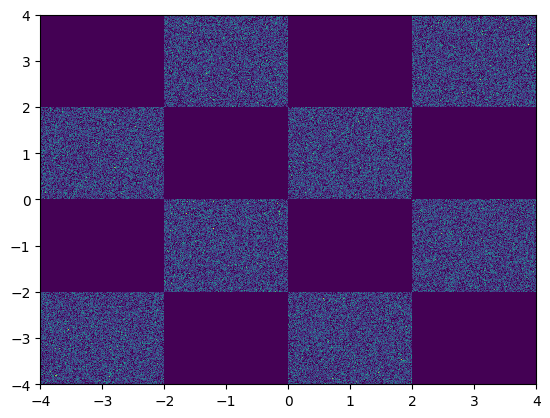

In [3]:
data_name = 'checkerboard'
size = 1000000
data_np = sample_2d(dataset=data_name, n_samples=size).numpy()
plot_data(plt, data_np)

## Toy example: Gaussian

Before doing the genral EBM, we will deal with a simple example to see how to compute automatically scores and then running SGD.

First, the code below shows you how to use [`torch.autograd.grad`](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html) in order to compute score:

In [4]:
theta = torch.zeros(2)
data = torch.randn(10,2)

In [5]:
x = data
x = x.requires_grad_()
logp = -torch.sum((x-theta)**2)/2

In [6]:
scores = torch.autograd.grad(logp, x)[0]

In [7]:
def my_score(x, theta=theta):
    return theta-x

In [8]:
torch.allclose(scores, my_score(data))

True

However, we want to take another derivative with respect to the parameter $\theta$ for the SGD algorithm. Let see how it goes with a fake loss as defined below:

In [9]:
x = data
x = x.requires_grad_()
theta = theta.requires_grad_()
logp = -torch.sum((x-theta)**2)/2
scores = torch.autograd.grad(logp, x)[0]
fake_loss = scores.norm()**2

In [10]:
theta.requires_grad

True

In [11]:
theta.grad

The code below will produce an error because by default, PyTorch do not keep the computation graph for the derivatives.

In [12]:
# produce an error
#fake_loss.backward()

Using `create_graph=True`, we tell PyTorch that we will take another derivative of score (which is already a derivative w.r.t. $x$).

In [13]:
x = data
x = x.requires_grad_()
theta = theta.requires_grad_()
logp = -torch.sum((x-theta)**2)/2
scores = torch.autograd.grad(logp, x, create_graph=True)[0]
fake_loss = scores.norm()**2

In [14]:
fake_loss.backward()

In [15]:
theta.grad

tensor([ 2.2893, 11.6755])

In [16]:
torch.allclose(theta.grad, 2*my_score(x).sum(0))

True

### Question 5 (code)

Recode the example above with a function computing the energy, the score and finally sample with Langevin MCMC. All functions should work with batches.

In [17]:
theta = torch.zeros(2)
def energy_fn(x, theta=theta):
    return torch.sum(((x-theta)**2) / 2, dim=1)

In [18]:
# should be True
torch.allclose(torch.sum(energy_fn(x)), -logp)

True

In [19]:
def score(x, fn = energy_fn):
    x = x.requires_grad_()
    return - torch.autograd.grad(torch.sum(energy_fn(x)), x, create_graph=True)[0]

In [20]:
# should be True
torch.allclose(score(x), my_score(x))

True

In [21]:
def sample_langevin(x, score=score, eps=0.1, n_steps=1000):
    for _ in range(n_steps):
        z = torch.randn_like(x)
        x = x + eps * score(x) + np.sqrt(2*eps)*z
    return x

In [22]:
data_name = 'gaussian'
size = 1000000
data_np = sample_2d(dataset=data_name, n_samples=size).numpy()
dtype=torch.float32
data_t = torch.from_numpy(data_np).type(dtype)

In [23]:
data_simu = sample_langevin(data_t, eps=0.1, n_steps=100)

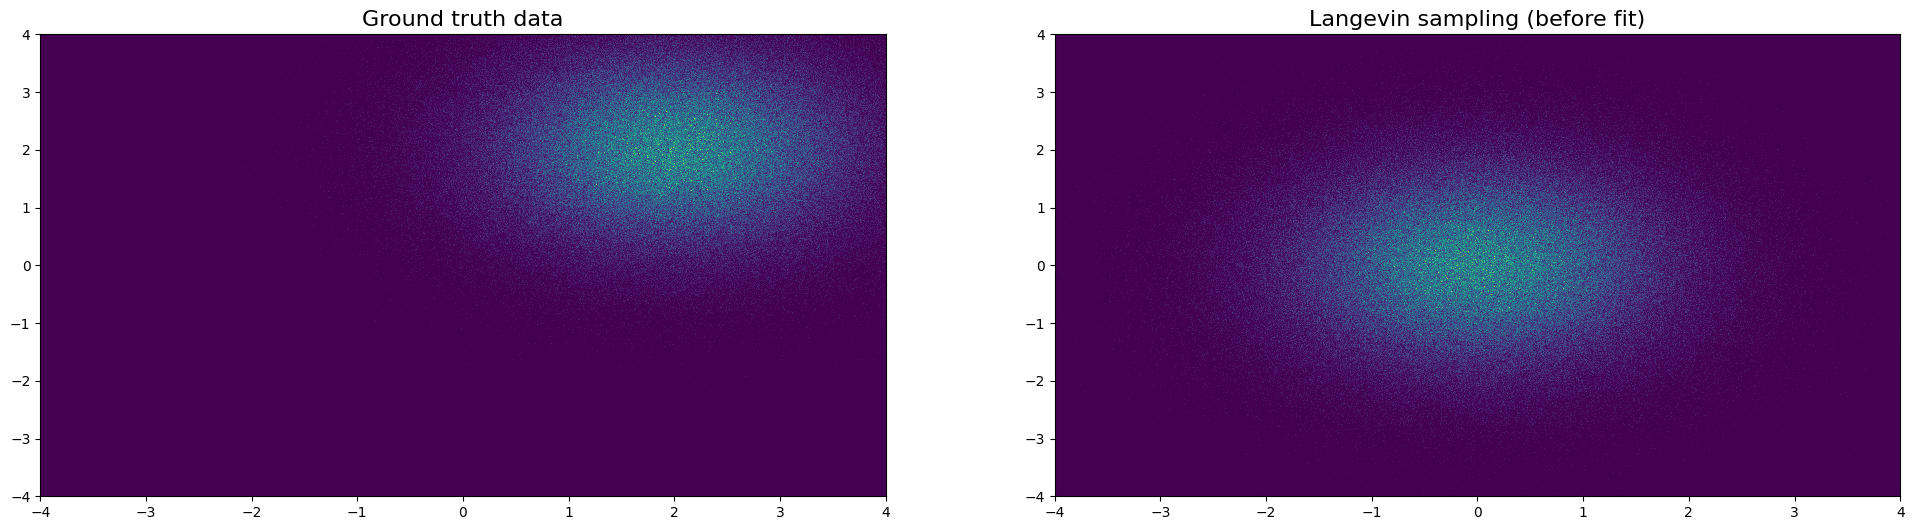

In [24]:
fig, axs = plt.subplots(figsize=(24, 6), ncols=2)
plot_data(axs[0], data_np)
axs[0].set_title('Ground truth data', fontsize=16)
plot_data(axs[1], data_simu.detach().numpy())
axs[1].set_title('Langevin sampling (before fit)', fontsize=16);

Here, you should have a mismatch between the ground truth and the Langevin sampling which is expected as you did not code the training step. The mean of the Gaussian for the ground truth is $(2,2)$ and the default mean for your (Gaussian) EBM  is $(0,0)$. So now you will code the training of your model. 

### Question 6 (code)

Now repackage your code above into a python class with methods:
- `energy_fn` taking as argument a batch of samples $x_1,\dots,x_B$ and computing the corresponding energies $(x_1-\theta)^2/2,\dots, (x_B-\theta)^2/2$.
- `score` taking as argument a batch of samples $x_1,\dots,x_B$ and computing the corresponding scores $s_\theta(x_1),\dots, s_\theta(x_B)$.
- `sample_langevin` taking as argument a batch of starting points $x_1,\dots, x_B$, a default step size `eps=0.1` and a default number of steps  `n_steps=1000`
- `dsm_loss` taking as argumenta batch of samples $x_1,\dots,x_B$ with a default parameter for the noise `sigma=0.1` and computing the corresponding (denoising score matching) loss.
- `train_epoch` taking as argument a `dataloader` and running SGD algorithm for one epoch.
- `fit` in order to train the model for several epoch (given to you below).

In [25]:
class Energy_Gaussian():
    def __init__(self, theta=theta, learning_rate =1e-3):
        self.theta = theta.requires_grad_()
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam([self.theta], lr=self.learning_rate)
        self.device='cpu'

    def energy_fn(self, x):
      return torch.sum((x-self.theta)**2 / 2, dim=1)

    def score(self, x):
      x = x.requires_grad_()
      energy = torch.sum(self.energy_fn(x))
      score = -torch.autograd.grad(energy, x, create_graph=True)[0]
      return score

    def sample_langevin(self, x, eps=0.1, n_steps=1000):
      for _ in range(n_steps):
        z = torch.randn_like(x)
        x = x + eps * self.score(x) + np.sqrt(2*eps)*z
      return x

    def dsm_loss(self, x, sigma=0.1):
      z = torch.randn_like(x)
      y = x + sigma * z
      loss = torch.mean((z/sigma + self.score(y))**2)
      return loss

    def train_epoch(self, dataloader):
      all_losses = []
      for data in dataloader:
        loss = self.dsm_loss(data)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        all_losses.append(loss.item())
      m_loss = np.mean(all_losses).astype(np.float32)
      return m_loss

    def fit(self, train_dataloader,
            n_epochs = 1,
            log_freq = 1,
            vis_freq = 1,
            vis_callback = None):

      total_epochs = n_epochs
      num_epochs = 0

      for epoch in range(n_epochs):
        num_epochs += 1
        # train one epoch
        loss = self.train_epoch(train_dataloader)

        if (log_freq is not None) and (num_epochs % log_freq == 0):
            print(
                f"[Epoch {num_epochs}/{total_epochs}]: loss: {loss}  theta: {self.theta.data}"
            )

        if (vis_callback is not None) and (num_epochs % vis_freq == 0):
            print("Visualizing")
            vis_callback(self)
      pass

In [26]:
dtype=torch.float32
data = torch.from_numpy(data_np).type(dtype)
loader_train = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

In [27]:
energy_gauss = Energy_Gaussian()

[Epoch 1/1]: loss: 99.4543685913086  theta: tensor([2.0086, 1.9762])
Visualizing


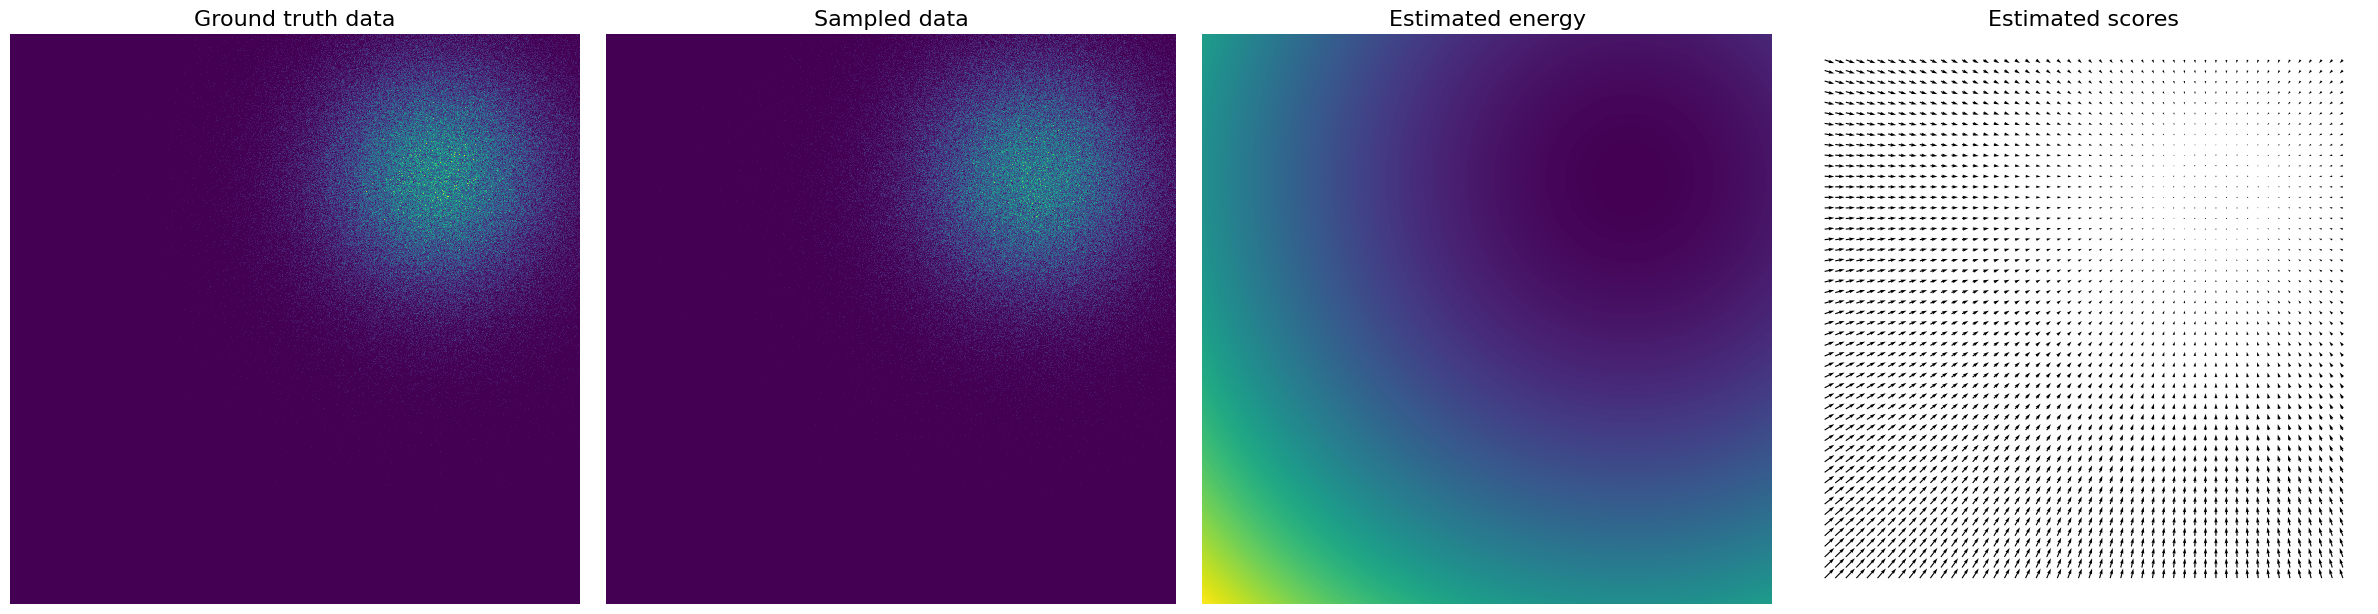

In [28]:
energy_gauss.fit(loader_train, vis_callback = functools.partial(
            visualize,
            data = data_np,
            steps = 100,
            eps = 0.1
        ))

We see that after only one epoch, we have a good estiamte. Now, we will deal with the more challenging dataset


## Energy model for the checkerboard

The neural network used to compute the energy is given below:

In [29]:
hidden_units = 128
my_mlp = nn.Sequential(
            nn.Linear(2, hidden_units),
            nn.Softplus(),
            nn.Linear(hidden_units, hidden_units),
            nn.Softplus(),
            nn.Linear(hidden_units, 1),
        )

### Question 7 (code)

Now adapt the example above to this more general setting by creating a PyTorch module.

In [30]:
class Energy(nn.Module):
    def __init__(self, net, learning_rate =1e-3, device = 'cpu'):
        super().__init__()
        self.device = device
        self.net = net.to(device=self.device)
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)

    def energy_fn(self, x):
      return self.net(x)

    def score(self, x):
      x = x.requires_grad_()
      energy = torch.sum(self.energy_fn(x))
      score = -torch.autograd.grad(energy, x, create_graph=True)[0]
      return score

    def sample_langevin(self, x, eps=0.1, n_steps=1000):
      for _ in range(n_steps):
        z = torch.randn_like(x)
        x = x + eps * self.score(x) + np.sqrt(2*eps)*z
      return x

    def dsm_loss(self, x, sigma=0.1):
      z = torch.randn_like(x)
      y = x + sigma * z
      loss = torch.sum((z/sigma + self.score(y))**2) / x.size(0)
      return loss

    def train_epoch(self, dataloader):
      all_losses = []
      for data in dataloader:
        data.to(self.device)
        self.optimizer.zero_grad()
        loss = self.dsm_loss(data)
        loss.backward()
        self.optimizer.step()
        all_losses.append(loss.item())
      m_loss = np.mean(all_losses).astype(np.float32)
      return m_loss

    def fit(self, train_dataloader,
            n_epochs = 5,
            batch_size = 100,
            log_freq = 1,
            vis_freq = 1,
            vis_callback = None):

        total_epochs = n_epochs
        num_epochs = 0

        for epoch in range(n_epochs):
            num_epochs += 1
            # train one epoch
            loss = self.train_epoch(train_dataloader)

            if (log_freq is not None) and (num_epochs % log_freq == 0):
                print(
                    f"[Epoch {num_epochs}/{total_epochs}]: loss: {loss}"
                )

            if (vis_callback is not None) and (num_epochs % vis_freq == 0):
                print("Visualizing")
                self.net.eval()
                vis_callback(self)
                self.net.train()
        pass

In [31]:
data_name = 'checkerboard'
size = 1000000
data_np = sample_2d(dataset=data_name, n_samples=size).numpy()

In [32]:
dtype=torch.float32
data = torch.from_numpy(data_np).type(dtype)
loader_train = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

In [33]:
energy_model = Energy(my_mlp)

[Epoch 1/5]: loss: 197.15589904785156
Visualizing


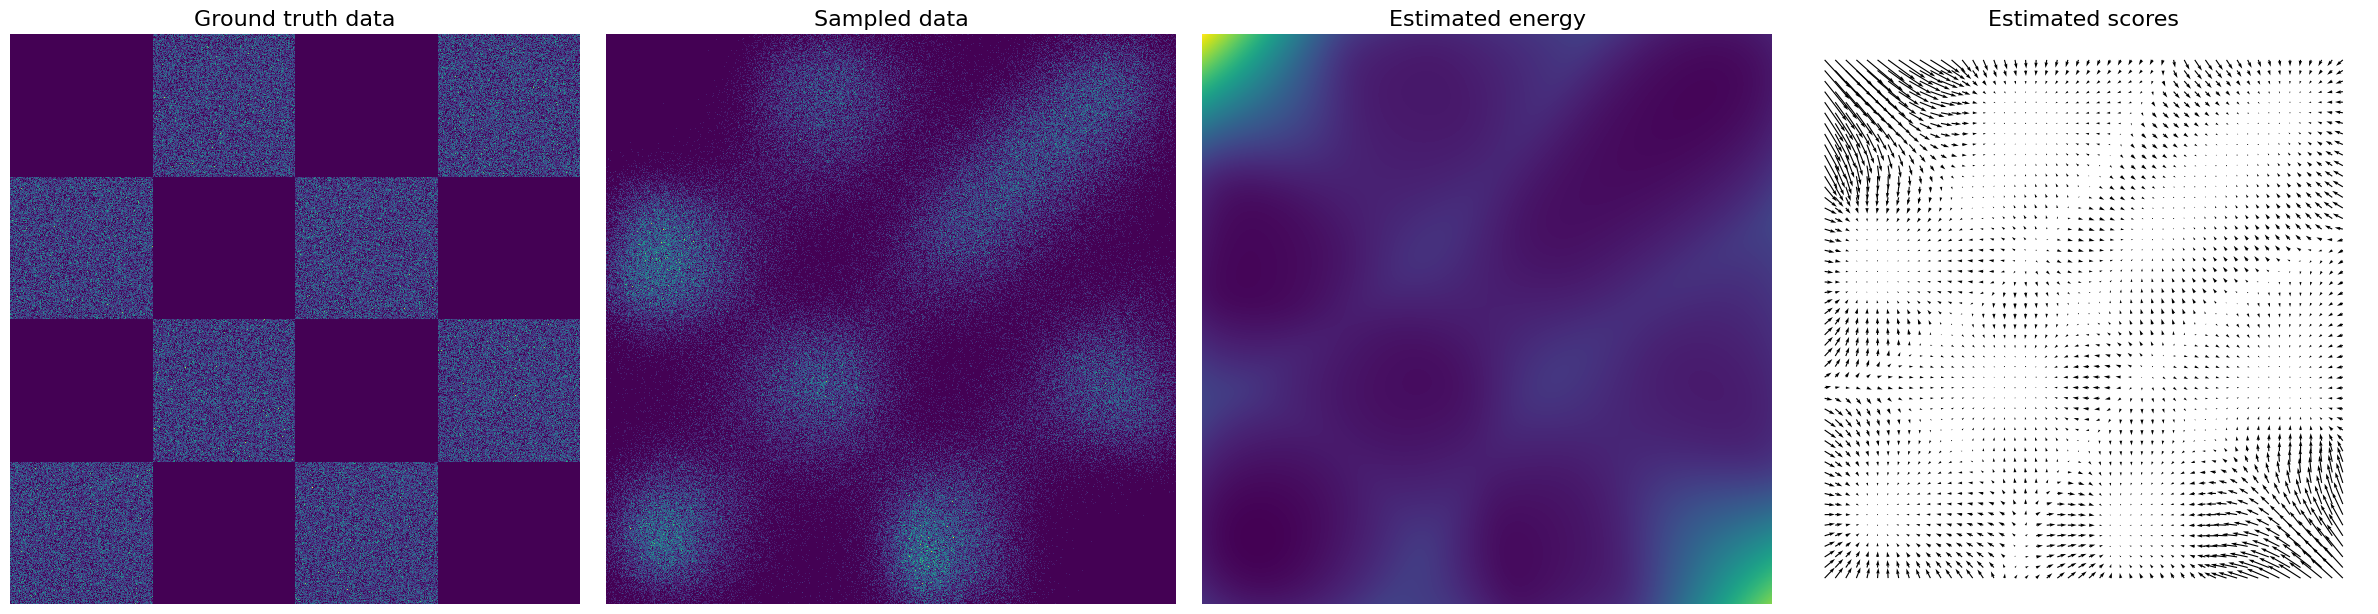

[Epoch 2/5]: loss: 192.7599639892578
Visualizing


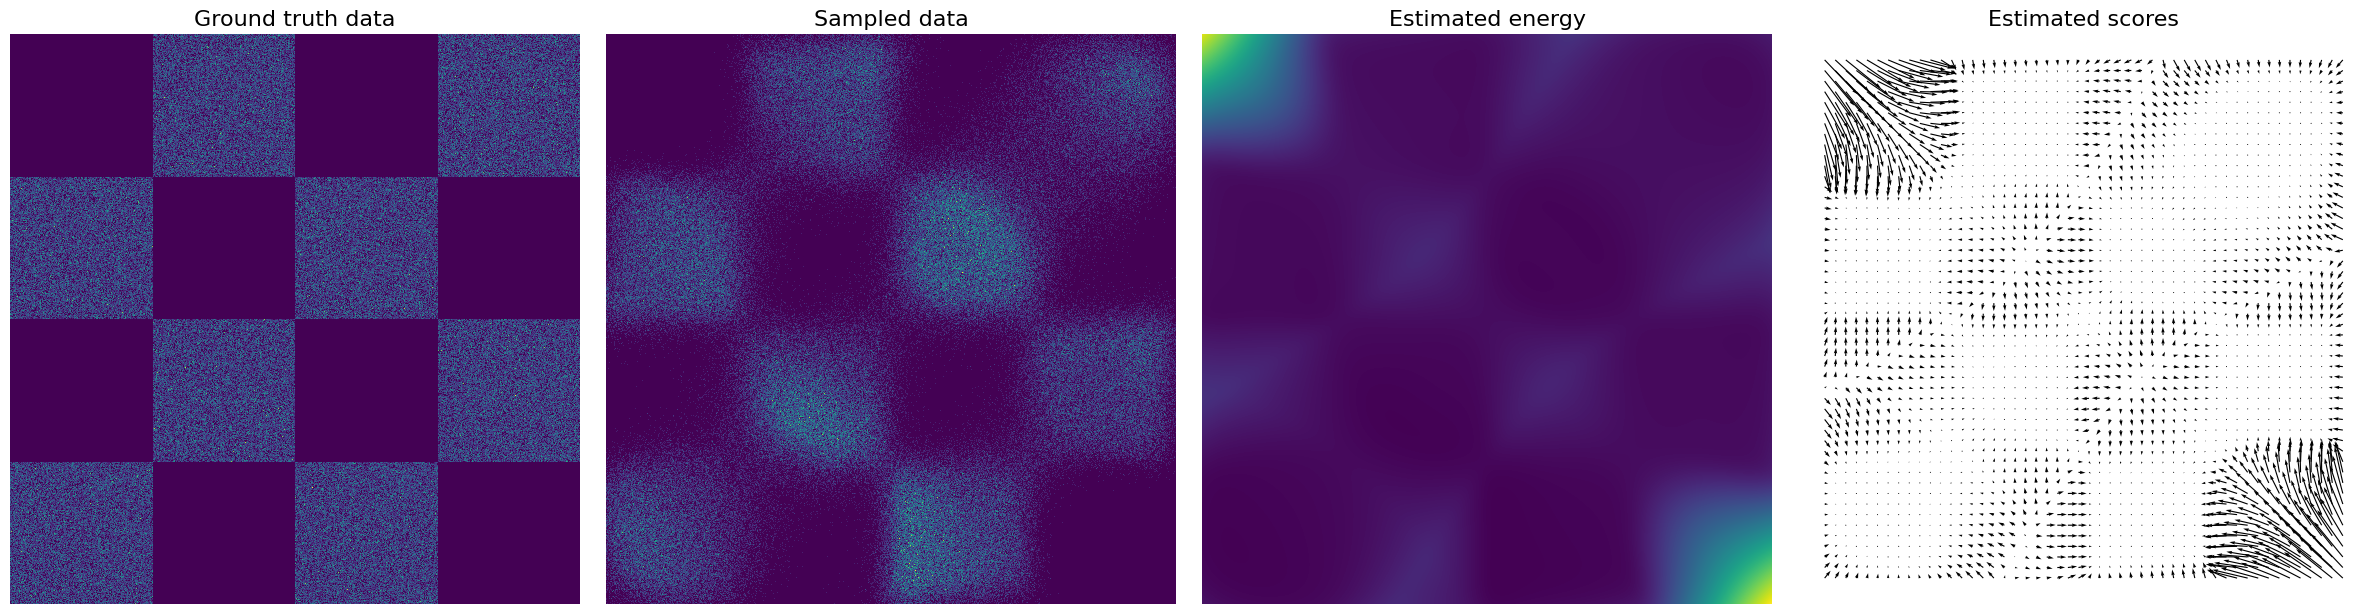

[Epoch 3/5]: loss: 188.8590545654297
Visualizing


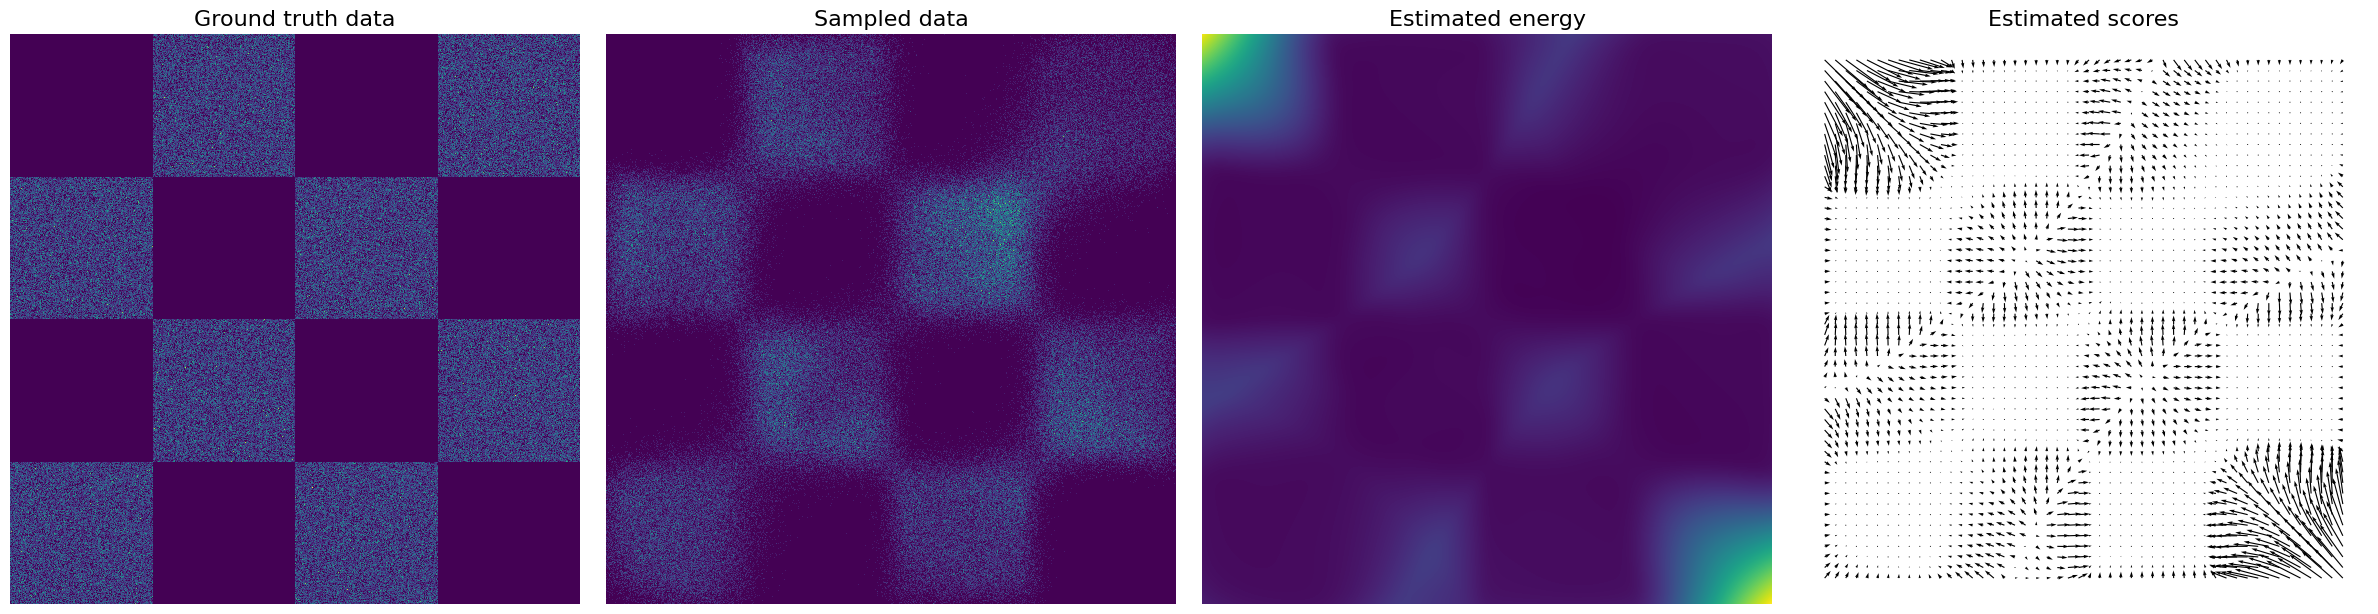

[Epoch 4/5]: loss: 186.9090118408203
Visualizing


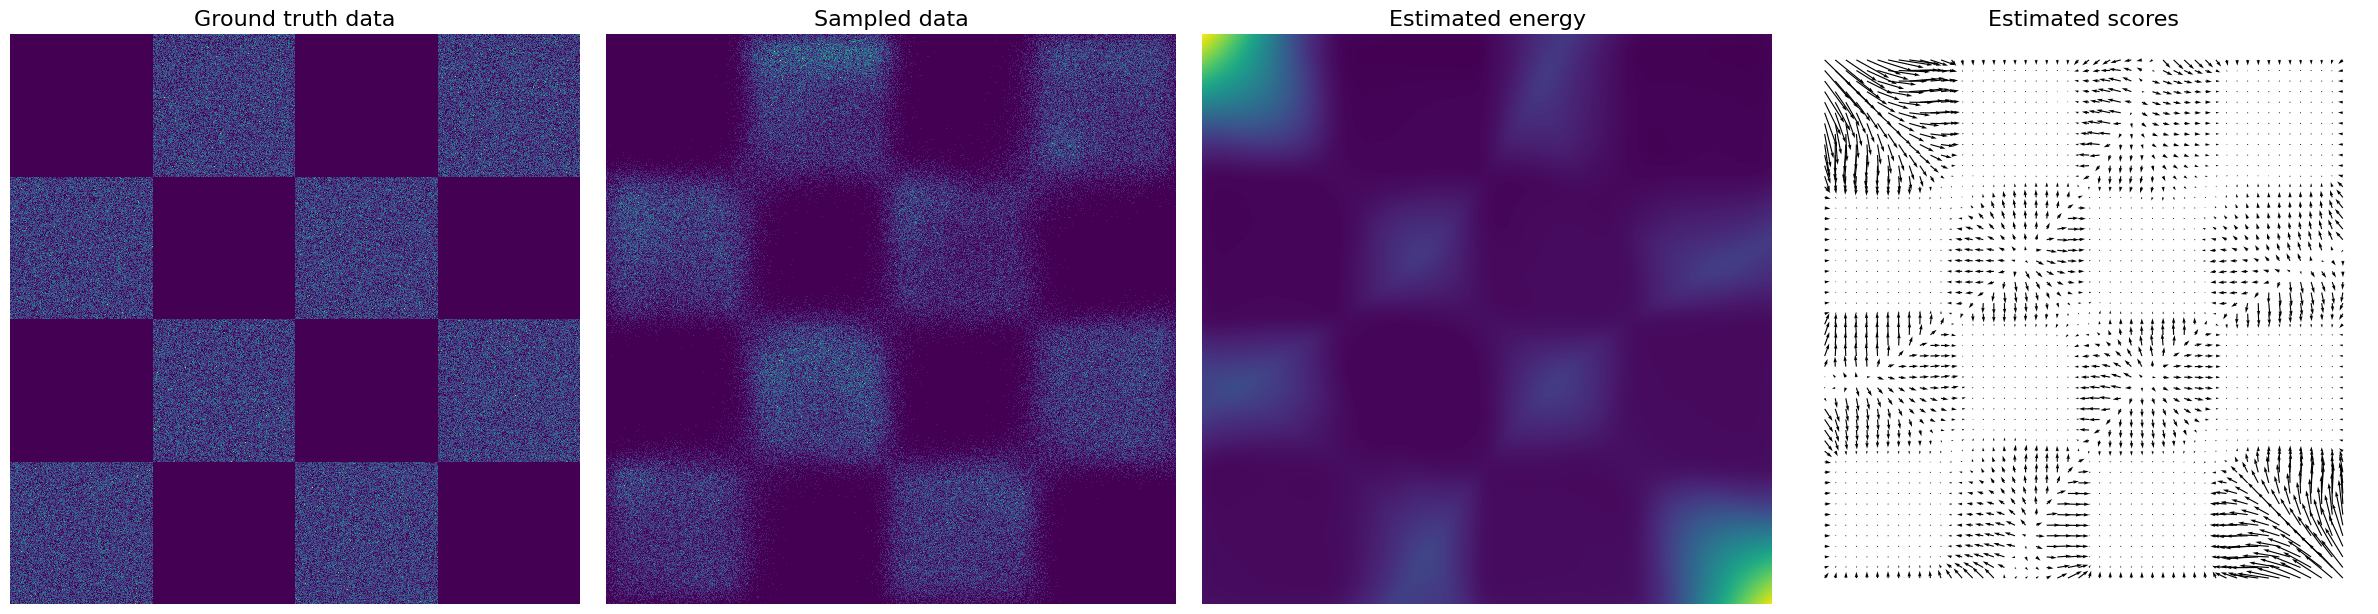

[Epoch 5/5]: loss: 186.38442993164062
Visualizing


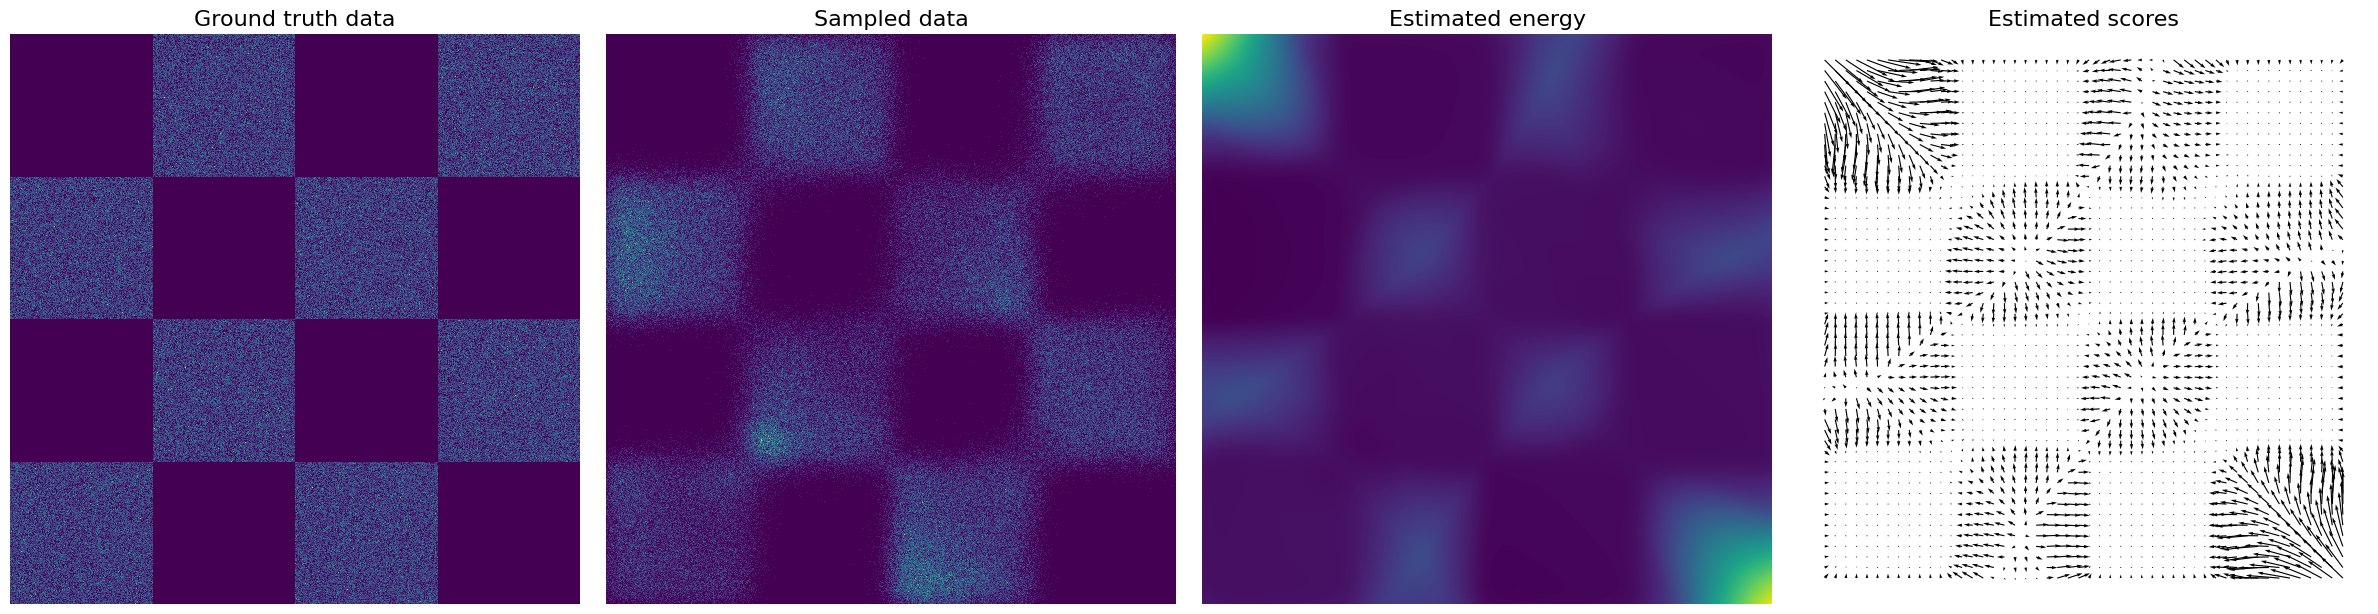

In [34]:
energy_model.fit(loader_train, vis_callback = functools.partial(
            visualize,
            data = data_np,
            steps = 100,
            eps = 0.01
        ))